In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [7]:
# Define paths
zip_file_path = "/content/drive/MyDrive/Brain Tumor Dataset.zip"
extract_to_path = "/content/drive/MyDrive/extracted_files"

# Create directory if not exists
os.makedirs(extract_to_path, exist_ok=True)

# Unzip the file
!unzip -o "$zip_file_path" -d "$extract_to_path"

print("Unzipping completed!")

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/drive/MyDrive/extracted_files/Training/glioma/Tr-gl_0723.jpg  
  inflating: /

In [9]:
# Define dataset path in Google Drive
dataset_path = "/content/drive/MyDrive/extracted_files"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

# Verify directory structure
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset path {dataset_path} does not exist. Please check the path.")
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Training path {train_path} does not exist. Please check the path.")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Testing path {test_path} does not exist. Please check the path.")

print("Training directory structure:")
for tumor_type in os.listdir(train_path):
    tumor_dir = os.path.join(train_path, tumor_type)
    if os.path.isdir(tumor_dir):  # Ensure it's a directory
        print(f"{tumor_type}: {len(os.listdir(tumor_dir))} images")
print("\nTesting directory structure:")
for tumor_type in os.listdir(test_path):
    tumor_dir = os.path.join(test_path, tumor_type)
    if os.path.isdir(tumor_dir):  # Ensure it's a directory
        print(f"{tumor_type}: {len(os.listdir(tumor_dir))} images")

Training directory structure:
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

Testing directory structure:
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images


In [10]:
import hashlib

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def list_files(base_path, hash_dict):
    data_types = ['Training', 'Testing']
    labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for data_type in data_types:
        for label in labels:
            folder_path = os.path.join(base_path, data_type, label)
            if not os.path.exists(folder_path):
                print(f"Skipping {folder_path}: directory does not exist.")
                continue
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith((".jpg", ".jpeg", ".png")):  # Support multiple image formats
                    img_path = os.path.join(folder_path, img_name)
                    try:
                        img_hash = compute_hash(img_path)
                        if img_hash in hash_dict:
                            hash_dict[img_hash].append((img_path, data_type))
                        else:
                            hash_dict[img_hash] = [(img_path, data_type)]
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")
                        continue

def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_info in hash_dict.items():
        if len(file_info) > 1:  # Duplicate found
            # Prioritize keeping the training image
            keep_path = None
            for path, data_type in file_info:
                if data_type == 'Training':
                    keep_path = path
                    break
            if not keep_path:  # If no training image, keep the first one
                keep_path = file_info[0][0]

            # Remove all other duplicates
            for path, _ in file_info:
                if path != keep_path:
                    print(f"Removing duplicate (hash: {hash_value}): {path}")
                    try:
                        os.remove(path)
                        duplicate_count += 1
                    except Exception as e:
                        print(f"Error removing {path}: {e}")
                        continue
    print(f"Removed {duplicate_count} duplicate images.")
    return duplicate_count

# Remove duplicates across Training and Testing directories
hash_dict = {}
list_files(dataset_path, hash_dict)
total_duplicates = remove_duplicates(hash_dict)
print(f"Total duplicates removed across sets: {total_duplicates}")

# Re-verify directory structure after removing duplicates
print("\nTraining directory structure after deduplication:")
for tumor_type in os.listdir(train_path):
    tumor_dir = os.path.join(train_path, tumor_type)
    if os.path.isdir(tumor_dir):  # Ensure it's a directory
        print(f"{tumor_type}: {len(os.listdir(tumor_dir))} images")
print("\nTesting directory structure after deduplication:")
for tumor_type in os.listdir(test_path):
    tumor_dir = os.path.join(test_path, tumor_type)
    if os.path.isdir(tumor_dir):  # Ensure it's a directory
        print(f"{tumor_type}: {len(os.listdir(tumor_dir))} images")

Removing duplicate (hash: b0481c04cf82055b53bed325556f744e): /content/drive/MyDrive/extracted_files/Testing/meningioma/Te-me_0135.jpg
Removing duplicate (hash: ab525628d00898aa6b1088d9c1d5a785): /content/drive/MyDrive/extracted_files/Training/meningioma/Tr-me_0281.jpg
Removing duplicate (hash: af3a4cf5d54bd454b733bfe3d2177b4a): /content/drive/MyDrive/extracted_files/Training/meningioma/Tr-me_0211.jpg
Removing duplicate (hash: af3a4cf5d54bd454b733bfe3d2177b4a): /content/drive/MyDrive/extracted_files/Training/meningioma/Tr-me_0366.jpg
Removing duplicate (hash: a501e6ea3748d3aebea8e8735268ec5b): /content/drive/MyDrive/extracted_files/Training/meningioma/Tr-me_0238.jpg
Removing duplicate (hash: 333ca271271562e025951545e76a8b0b): /content/drive/MyDrive/extracted_files/Training/meningioma/Tr-me_0251.jpg
Removing duplicate (hash: 3cb1d6594ea1a7391608e9bc8245529c): /content/drive/MyDrive/extracted_files/Testing/meningioma/Te-me_0143.jpg
Removing duplicate (hash: 832c3e0243e8fafe4313d899e233285

In [11]:
def load_and_label_data(base_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(base_path))
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(base_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            images.append(img_path)
            labels.append(idx)
    return images, labels, class_names

train_images, train_labels, class_names = load_and_label_data(train_path)
test_images, test_labels, _ = load_and_label_data(test_path)

all_images = train_images + test_images
all_labels = train_labels + test_labels

train_imgs, temp_imgs, train_lbls, temp_lbls = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_lbls, test_lbls = train_test_split(
    temp_imgs, temp_lbls, test_size=0.5, stratify=temp_lbls, random_state=42)

print(f"\nDataset split: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")


Dataset split: 5380 train, 673 val, 673 test


In [28]:
import shutil

IMG_SIZE = 299
BATCH_SIZE = 32

# Define paths
base_train_path = r'/content/drive/MyDrive/extracted_files/Training'  # Source directory
train_path = 'split_train'  # Destination for new training set
val_path = 'split_val'      # Destination for new validation set
test_path = r'/content/drive/MyDrive/extracted_files/Testing'

# Verify base_train_path exists
if not os.path.exists(base_train_path):
    raise FileNotFoundError(f"Base training directory {base_train_path} does not exist. Please check the path.")

# Split training data into train and validation sets
def split_train_val(base_train_path, train_path, val_path, val_split=0.1):
    # Clear existing directories if they exist
    if os.path.exists(train_path):
        shutil.rmtree(train_path)
    if os.path.exists(val_path):
        shutil.rmtree(val_path)
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)

    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for class_name in class_names:
        class_dir = os.path.join(base_train_path, class_name)
        # Check if class directory exists
        if not os.path.exists(class_dir):
            raise FileNotFoundError(f"Class directory {class_dir} does not exist. Check base_train_path contents.")

        # List images in the class directory
        images = os.listdir(class_dir)
        # Filter for image files (e.g., .jpg, .png) to avoid hidden files
        images = [img for img in images if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Check if there are images to split
        if len(images) == 0:
            raise ValueError(f"Class directory {class_dir} is empty. Ensure it contains images.")

        # Split images into train and val
        train_imgs, val_imgs = train_test_split(images, test_size=val_split, random_state=42)

        # Create destination directories
        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_name), exist_ok=True)

        # Copy images to new directories
        for img in train_imgs:
            shutil.copy(os.path.join(class_dir, img), os.path.join(train_path, class_name, img))
        for img in val_imgs:
            shutil.copy(os.path.join(class_dir, img), os.path.join(val_path, class_name, img))

    # Print new directory structure
    print("New training directory structure after split (used for training):")
    for class_name in class_names:
        train_class_dir = os.path.join(train_path, class_name)
        print(f"{class_name}: {len(os.listdir(train_class_dir))} images")
    print("\nNew validation directory structure after split (used for validation during training):")
    for class_name in class_names:
        val_class_dir = os.path.join(val_path, class_name)
        print(f"{class_name}: {len(os.listdir(val_class_dir))} images")

# Call the function with the correct base_train_path
split_train_val(base_train_path, train_path, val_path, val_split=0.1)

# Define preprocessing functions
def contrast_stretching(image):
    img_min, img_max = np.min(image), np.max(image)
    if img_max == img_min:
        return image
    stretched = (image - img_min) / (img_max - img_min)
    return stretched

def custom_preprocessing(image):
    image = contrast_stretching(image)
    image = image + np.random.normal(0, 0.05, image.shape)
    image = np.clip(image, 0, 1)
    return image

New training directory structure after split (used for training):
glioma: 1188 images
meningioma: 1199 images
notumor: 1279 images
pituitary: 1300 images

New validation directory structure after split (used for validation during training):
glioma: 133 images
meningioma: 134 images
notumor: 143 images
pituitary: 145 images


27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
import os

# Define generators with added augmentation for regularization
IMG_SIZE = 299
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    preprocessing_function=custom_preprocessing
)

test_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Class weights
class_weight_dict = {0: 2.0, 1: 2.5, 2: 1.0, 3: 1.0}
print("Class weights:", class_weight_dict)

# Define checkpoint path
checkpoint_dir = '/content/checkpoints_b1'
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoints at 10, 20, 30
checkpoint_10 = ModelCheckpoint(
    os.path.join(checkpoint_dir, 'model_epoch_10.keras'),
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)
checkpoint_20 = ModelCheckpoint(
    os.path.join(checkpoint_dir, 'model_epoch_20.keras'),
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)
checkpoint_30 = ModelCheckpoint(
    os.path.join(checkpoint_dir, 'model_epoch_30.keras'),
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# Define callbacks list
callbacks = [reduce_lr, checkpoint_10, checkpoint_20, checkpoint_30]

# Compile the model
from tensorflow.keras.optimizers import Adamax
model.compile(
    optimizer=Adamax(learning_rate=0.001, weight_decay=1e-4),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy', Precision(), Recall()]
)

# Train from Epoch 1
print("Starting training from Epoch 1.")
history = model.fit(
    train_generator,
    epochs=13,  # Set to desired number of epochs
    initial_epoch=0,  # Start from epoch 1
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Found 4966 images belonging to 4 classes.
Found 555 images belonging to 4 classes.
Class weights: {0: 2.0, 1: 2.5, 2: 1.0, 3: 1.0}
Starting training from Epoch 1.
Epoch 1/13
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8927 - loss: 0.0154 - precision_1: 0.9242 - recall_1: 0.8581
Epoch 1: saving model to /content/checkpoints_b1/model_epoch_10.keras

Epoch 1: saving model to /content/checkpoints_b1/model_epoch_20.keras

Epoch 1: saving model to /content/checkpoints_b1/model_epoch_30.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.8928 - loss: 0.0154 - precision_1: 0.9243 - recall_1: 0.8581 - val_accuracy: 0.9099 - val_loss: 0.0094 - val_precision_1: 0.9191 - val_recall_1: 0.9009 - learning_rate: 0.0010
Epoch 2/13
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.9267 - loss: 0.0077 - precision_1: 0.9504 - recall_1: 0.9032
Epoch 2: saving model to /content/checkpoints_b1/model_epoch_10.keras

Epoch 2: saving model to /content/checkpoints_b1/model_epoch_20.ker

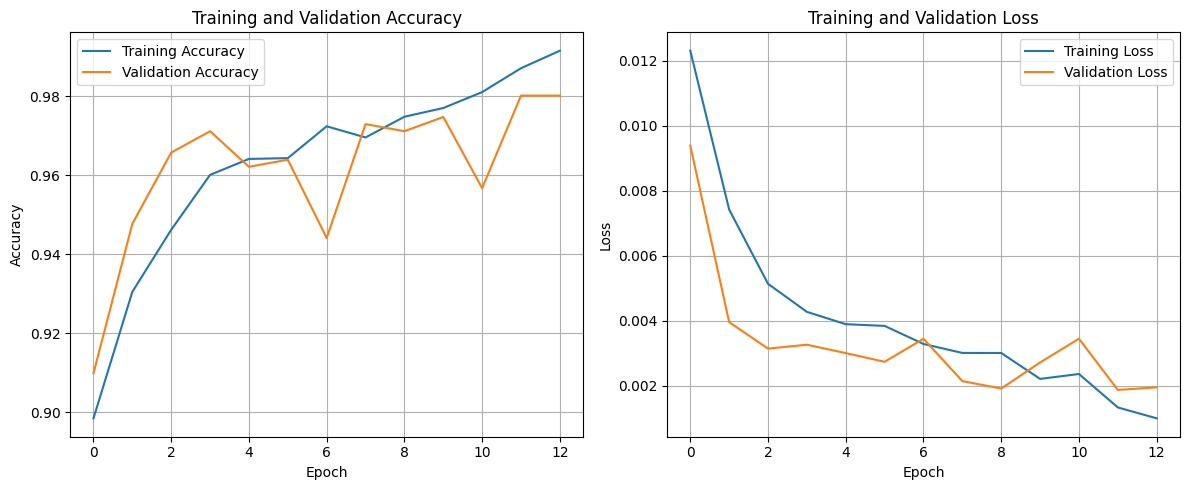

In [17]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Found 1205 images belonging to 4 classes.
Loading checkpoint from Epoch 15 for final evaluation.
Evaluating on test set...
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 631ms/step - accuracy: 0.9938 - loss: 6.0137e-04 - precision_2: 0.9950 - recall_2: 0.9916
Test Loss: 0.0007
Test Accuracy: 0.9934
Test Precision: 0.9942
Test Recall: 0.9925
Generating predictions for confusion matrix...
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 603ms/step

Confusion Matrix:
[[296   2   0   1]
 [  3 298   1   0]
 [  0   0 309   0]
 [  0   2   0 293]]


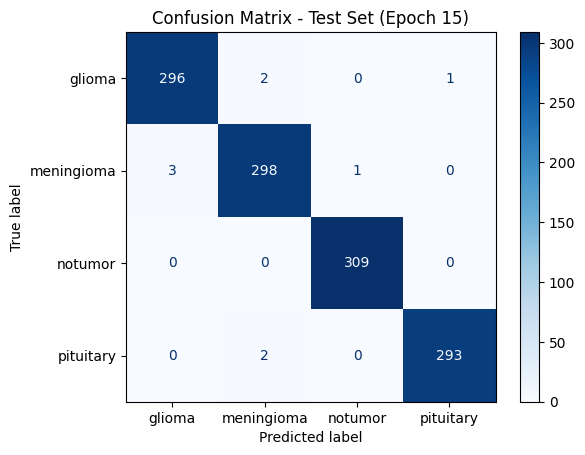


Per-Class Metrics:
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       299
  meningioma       0.99      0.99      0.99       302
     notumor       1.00      1.00      1.00       309
   pituitary       1.00      0.99      0.99       295

    accuracy                           0.99      1205
   macro avg       0.99      0.99      0.99      1205
weighted avg       0.99      0.99      0.99      1205



In [18]:
# Define generators (only need test generator for evaluation)
IMG_SIZE = 299
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing
)

# Test generator for final evaluation
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important for evaluation and confusion matrix
)

# Define checkpoint path
checkpoint_dir = '/content/checkpoints_b1'
os.makedirs(checkpoint_dir, exist_ok=True)

# Load the Epoch 15 checkpoint (saved as model_epoch_30.keras due to previous bug)
print("Loading checkpoint from Epoch 15 for final evaluation.")
model.load_weights(os.path.join(checkpoint_dir, 'model_epoch_30.keras'))  # Epoch 15 checkpoint

# Recompile to ensure settings are applied
from tensorflow.keras.optimizers import Adamax
model.compile(
    optimizer=Adamax(learning_rate=0.0005, weight_decay=1e-4),
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy', Precision(), Recall()]
)

# Evaluate on test set
print("Evaluating on test set...")
test_metrics = model.evaluate(
    test_generator,
    verbose=1
)
print(f"Test Loss: {test_metrics[0]:.4f}")
print(f"Test Accuracy: {test_metrics[1]:.4f}")
print(f"Test Precision: {test_metrics[2]:.4f}")
print(f"Test Recall: {test_metrics[3]:.4f}")

# Generate predictions for confusion matrix
print("Generating predictions for confusion matrix...")
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class indices
y_true_classes = test_generator.classes  # True class indices

# Class names (based on directory structure)
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set (Epoch 15)")
plt.show()

# Per-class metrics (optional, for deeper analysis)
from sklearn.metrics import classification_report
print("\nPer-Class Metrics:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

Found 1205 images belonging to 4 classes.


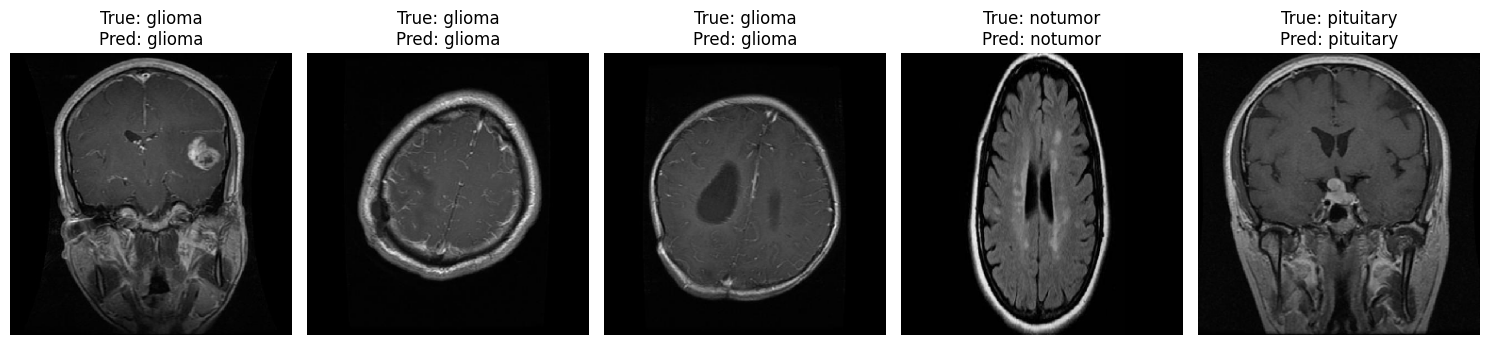

In [23]:
# Define test generator for random predictions
IMG_SIZE = 299
BATCH_SIZE = 32

test_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get all test image file paths and their true labels
test_file_paths = test_generator.filepaths
test_labels = test_generator.classes

# Select 5 random test images
num_samples = 5
random_indices = random.sample(range(len(test_file_paths)), num_samples)
random_images = [test_file_paths[i] for i in random_indices]
random_true_labels = [test_labels[i] for i in random_indices]

# Function to preprocess image for prediction
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = custom_preprocessing(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Predict and visualize random images
plt.figure(figsize=(15, 5))
for i, (img_path, true_label) in enumerate(zip(random_images, random_true_labels)):
    # Preprocess image
    img_array = preprocess_image(img_path)

    # Predict
    pred = model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred, axis=1)[0]
    pred_label = class_names[pred_class]
    true_label_name = class_names[true_label]

    # Plot image
    plt.subplot(1, num_samples, i + 1)
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.title(f"True: {true_label_name}\nPred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()